In [0]:
from pyiris.ingestion.config.file_system_config import FileSystemConfig
from pyiris.ingestion.extract import ExtractService, FileReader
from pyiris.ingestion.load import LoadService, FileWriter
from pyiris.infrastructure import Spark

import pyspark.sql.functions as f 
from pyspark.sql import  Row, Window

import pyspark as ps
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,cross_validate
from scipy.stats import uniform, randint, loguniform #,quniform
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error,make_scorer,mean_absolute_error, mean_squared_error,r2_score

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
# from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso

from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor

from sklearn.preprocessing import StandardScaler, MinMaxScaler,LabelEncoder
from sklearn.base import clone

import hyperopt
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK, Trials
 
import mlflow
from mlflow import MlflowClient

# import pymer4
# from pymer4.models import Lmer

from datetime import datetime
import os, sys
import json

import re
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.optim as optim
from scipy.special import gammaln  # for Poisson and Gamma likelihoods
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import math
import re
import matplotlib.pyplot as plt

import logging
logging.getLogger("urllib3").setLevel(logging.ERROR)
pyiris_spark = Spark()

# Classe

In [0]:
class GLMM:
    def __init__(self, X=None, y=None, trials=None, groups=None, distribution='gaussian', link='identity',
                random_effect_cols=None, formula=None, data=None, regularization=None, reg_lambda=0.0):
        """
        Parameters:
        - Either provide X (n x p numpy array or DataFrame), y (n,), groups, and random_effect_cols
        OR supply a formula (R-style string) and a pandas DataFrame (data).
        - distribution: one of 'gaussian', 'binomial', 'gamma', 'poisson'
        - link: one of 'identity', 'log', 'logit'
        - trials: number of trials for each binomial observation (only needed for binomial)
        - groups: dict mapping group name -> group values (if not using formula)
        - random_effect_cols: dict mapping group name -> list of indices in X (if not using formula)
        - formula: R-style formula with support for multiple grouping variables
        - data: pandas DataFrame (required if formula is provided)
        - regularization: None, 'L1', or 'L2'
        - reg_lambda: regularization coefficient (nonnegative float)
        """
        self.distribution = distribution.lower()
        self.link = link.lower()
        self.regularization = regularization
        self.reg_lambda = reg_lambda
        self.formula = formula
        self.cat_encodings = {}  # Will store categorical variable encodings
        
        if formula is not None and data is not None:
            # Use our formula parser
            self.formula = formula
            X, y, trials, groups, group_vars, random_effect_cols, fixed_colnames = self.parse_formula(formula, data)
            self.fixed_colnames = fixed_colnames
            self.group_vars = group_vars
            self.trials = torch.tensor(trials, dtype=torch.float32).view(-1, 1) if trials is not None else None
        else:
            if X is None or y is None or groups is None:
                raise ValueError("Either supply (X, y, groups, random_effect_cols) or (formula and data)")
            # If X is provided as a DataFrame, get its column names
            if isinstance(X, pd.DataFrame):
                self.fixed_colnames = list(X.columns)
                X = X.values
            else:
                # If X is a numpy array, we assume columns are numbered
                self.fixed_colnames = [f"X{i}" for i in range(X.shape[1])]
            
            # In this case, we need to update the group handling
            if not isinstance(groups, dict):
                # Convert to dict format if provided as single group
                if random_effect_cols is None:
                    random_effect_cols = {'Group': [0]}  # Default to random intercept
                else:
                    random_effect_cols = {'Group': random_effect_cols}
                groups = {'Group': groups}
            
            self.group_vars = list(groups.keys())
                
            # For binomial with trials
            if self.distribution == 'binomial' and trials is not None:
                self.trials = torch.tensor(trials, dtype=torch.float32).view(-1, 1)
            else:
                self.trials = None
        
        # Store fixed effects design matrix and response
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)
        self.n, self.p = self.X.shape
        
        # Process multiple groups
        self.groups = groups
        self.group_data = {}  # Will store processed group data
        
        # Initialize parameters for each group
        self.random_effect_cols = random_effect_cols
        self.beta = nn.Parameter(torch.zeros(self.p, 1, dtype=torch.float32))
        
        # Create random effects parameters for each group
        self.b = {}  # Dict mapping group name -> random effects parameter
        self.log_sigma_b = {}  # Dict mapping group name -> log std dev parameter
        
        for group_var in self.group_vars:
            group_values = np.array(groups[group_var])
            unique_groups, group_idx = np.unique(group_values, return_inverse=True)
            
            self.group_data[group_var] = {
                'group_idx': torch.tensor(group_idx, dtype=torch.long),
                'n_groups': len(unique_groups),
                'unique_groups': unique_groups
            }
            
            # Get random effect columns for this grouping variable
            group_re_cols = random_effect_cols[group_var]
            d = len(group_re_cols)
            
            # Build random effect design matrix Z for this group
            Z = np.zeros((self.n, d))
            for j, col_idx in enumerate(group_re_cols):
                # For random intercept (or any other column), use the corresponding X column
                Z[:, j] = self.X[:, col_idx].detach().numpy().ravel()
            
            self.group_data[group_var]['Z'] = torch.tensor(Z, dtype=torch.float32)
            self.group_data[group_var]['d'] = d
            self.group_data[group_var]['random_effect_cols'] = group_re_cols
            
            # Initialize random effects b for this group (n_groups x d)
            self.b[group_var] = nn.Parameter(torch.zeros(len(unique_groups), d, dtype=torch.float32))
            # Initialize log std dev of random effects for this group (d-dimensional vector)
            self.log_sigma_b[group_var] = nn.Parameter(torch.zeros(d, dtype=torch.float32))
        
        # For gaussian, also estimate residual sigma_y; for gamma, estimate shape phi
        if self.distribution == 'gaussian':
            self.log_sigma_y = nn.Parameter(torch.tensor(0.0, dtype=torch.float32))
        elif self.distribution == 'gamma':
            self.log_phi = nn.Parameter(torch.tensor(0.0, dtype=torch.float32))
            
        # Collect parameters to optimize
        self.params = [self.beta]
        for group_var in self.group_vars:
            self.params.append(self.b[group_var])
            self.params.append(self.log_sigma_b[group_var])
        
        if self.distribution == 'gaussian':
            self.params.append(self.log_sigma_y)
        elif self.distribution == 'gamma':
            self.params.append(self.log_phi)
            
        self.loss_history = []

    def inverse_link(self, eta, link):
        """Helper: Inverse Link Functions"""
        if link == 'identity':
            return eta
        elif link == 'log':
            return torch.exp(eta)
        elif link == 'logit':
            return torch.sigmoid(eta)
        else:
            raise ValueError("Link not recognized.")

    def loglik_gaussian(self, y, mu, sigma_y):
        """Helper: Log-likelihood function for Gaussian distribution"""
        ll = -0.5 * torch.log(2 * math.pi * sigma_y**2) - 0.5 * ((y - mu)**2) / (sigma_y**2)
        return ll

    def loglik_binomial(self, y, mu, trials=None):
        """Helper: Log-likelihood function for Binomial distribution
        
        Args:
            y: Success counts
            mu: Probability of success
            trials: Number of trials (if None, assumes binary trials)
        """
        eps = 1e-6
        mu = torch.clamp(mu, eps, 1 - eps)
        
        if trials is not None:
            # Binomial distribution with multiple trials
            failures = trials - y
            ll = y * torch.log(mu) + failures * torch.log(1 - mu)
            # Add binomial coefficient terms
            # Note: We omit the binomial coefficient as it's a constant w.r.t parameters
        else:
            # Binary case (Bernoulli)
            ll = y * torch.log(mu) + (1 - y) * torch.log(1 - mu)
            
        return ll

    def loglik_poisson(self, y, mu):
        """Helper: Log-likelihood function for Poisson distribution"""
        ll = -mu + y * torch.log(mu) - torch.lgamma(y + 1)
        return ll

    def loglik_gamma(self, y, mu, phi):
        """Helper: Log-likelihood function for Gamma distribution"""
        # Parameterization: E(y)=mu, shape=phi.
        eps = 1e-6
        mu = torch.clamp(mu, eps, None)
        ll = (phi * torch.log(phi/mu) - torch.lgamma(phi)) + (phi - 1)*torch.log(y) - (phi*y/mu)
        return ll

    def parse_formula(self, formula, data):
        """
        Parse an R-style formula with enhanced support for:
        - Multiple random effects terms with different grouping variables
        - Automatic detection and encoding of categorical variables
        
        Expected forms: 
        - "y ~ x1 + x2 + (1 + x2 | group1) + (1 | group2)"
        - "cbind(win, loss) ~ x1 + x2 + (1 | group)" for binomial with trial size > 1
        
        Returns:
        X: fixed effects design matrix as numpy array (including intercept)
        y: response vector (numpy array)
        trials: total number of trials for binomial (numpy array or None)
        groups: grouping variables (dict mapping group name -> numpy array)
        group_vars: list of grouping variable names
        random_effect_cols: dict mapping group name -> list of indices in X for random slopes
        fixed_colnames: list of column names in X
        """
        import re
        import numpy as np
        import pandas as pd
        
        # Split formula at '~'
        lhs, rhs = formula.split("~")
        lhs = lhs.strip()
        rhs = rhs.strip()
        
        # Parse response variable
        trials = None
        if lhs.startswith("cbind(") and lhs.endswith(")"):
            # Extract success and failure counts for binomial
            inner = lhs[6:-1]  # Remove cbind( and )
            success_var, failure_var = [s.strip() for s in inner.split(",")]
            
            # Extract success and failure counts from data
            successes = data[success_var].values
            failures = data[failure_var].values
            
            # Calculate total trials and response (proportion of successes)
            trials = successes + failures
            y = successes
            
            # Set distribution to binomial if not already set
            if self.distribution != 'binomial':
                print(f"Warning: Changing distribution from '{self.distribution}' to 'binomial' based on formula.")
                self.distribution = 'binomial'
                
            # Default to logit link for binomial if not specified
            if self.link == 'identity':
                print("Warning: Changing link from 'identity' to 'logit' for binomial model.")
                self.link = 'logit'
        else:
            # Standard single response variable
            response = lhs
            y = data[response].values
        
        # Find all random effect terms: patterns like "( ... | ... )"
        rand_terms = []
        rand_pattern = r"\((.*?)\s*\|\s*(.*?)\)"
        
        # Extract all random effect terms
        for match in re.finditer(rand_pattern, rhs):
            rand_predictors = match.group(1).strip()  # e.g., "1 + x2"
            group_var = match.group(2).strip()        # e.g., "group"
            rand_terms.append((rand_predictors, group_var))
        
        # Remove all random terms from rhs
        fixed_part = re.sub(r"\(.*?\)", "", rhs)
        
        # Fixed effects: split remaining rhs by '+' and remove any empty parts
        fixed_terms = [term.strip() for term in fixed_part.split("+") if term.strip() and term.strip() != "-1"]
        
        # Always include an intercept if not explicitly removed
        include_intercept = not (("-1" in fixed_part) or ("- 1" in fixed_part))
        
        # Identify categorical variables in fixed terms
        categorical_vars = []
        numerical_vars = []
        
        for term in fixed_terms:
            if term in data.columns:
                # Check if variable is categorical or should be treated as such
                if pd.api.types.is_categorical_dtype(data[term]) or pd.api.types.is_object_dtype(data[term]):
                    categorical_vars.append(term)
                else:
                    numerical_vars.append(term)
        
        # Create dummy variables for categorical variables
        X_dummies_dict = {}
        cat_encodings = {}  # Store encodings for prediction
        
        for cat_var in categorical_vars:
            # Get dummies, drop first category to avoid collinearity
            dummies = pd.get_dummies(data[cat_var], prefix=cat_var, drop_first=True)
            X_dummies_dict[cat_var] = dummies
            
            # Store encoding information for future prediction
            categories = data[cat_var].unique()
            cat_encodings[cat_var] = {
                'categories': categories,
                'dummy_cols': dummies.columns.tolist()
            }
        
        # Store the categorical encodings as a class attribute
        self.cat_encodings = cat_encodings
        
        # Build fixed effects design matrix X
        n = data.shape[0]
        X_parts = []
        
        # Start with intercept if needed
        if include_intercept:
            X_parts.append(np.ones((n, 1)))
            fixed_colnames = ["Intercept"]
        else:
            fixed_colnames = []
        
        # Add numerical variables
        if numerical_vars:
            X_num = data[numerical_vars].values
            X_parts.append(X_num)
            fixed_colnames.extend(numerical_vars)
        
        # Add categorical dummy variables
        for cat_var in categorical_vars:
            dummies = X_dummies_dict[cat_var]
            X_parts.append(dummies.values)
            fixed_colnames.extend(dummies.columns.tolist())
        
        # Combine all parts into the design matrix
        if X_parts:
            X = np.hstack(X_parts)
        else:
            # Fallback to just intercept if no predictors
            X = np.ones((n, 1))
            fixed_colnames = ["Intercept"]
        
        # Process random effects terms
        groups = {}  # Dict mapping group var name to group values array
        random_effect_cols = {}  # Dict mapping group var name to list of indices
        group_vars = []  # List of group variable names
        
        for rand_pred, group_var in rand_terms:
            group_vars.append(group_var)
            groups[group_var] = data[group_var].values
            
            # Split rand_predictors by '+'
            tokens = [tok.strip() for tok in rand_pred.split("+") if tok.strip()]
            # For each token, map to an index in fixed_colnames
            group_cols = []
            
            for tok in tokens:
                if tok == "1" and "Intercept" in fixed_colnames:
                    # Random intercept corresponds to intercept column index
                    intercept_idx = fixed_colnames.index("Intercept")
                    group_cols.append(intercept_idx)
                elif tok in fixed_colnames:
                    idx = fixed_colnames.index(tok)
                    group_cols.append(idx)
                elif tok in categorical_vars:
                    # Handle categorical variables - all dummy columns should be included
                    for dummy_col in cat_encodings[tok]['dummy_cols']:
                        if dummy_col in fixed_colnames:
                            idx = fixed_colnames.index(dummy_col)
                            group_cols.append(idx)
                else:
                    # Check if token is a dummy variable from categorical variable
                    for cat_var, encoding in cat_encodings.items():
                        if tok in encoding['dummy_cols']:
                            idx = fixed_colnames.index(tok)
                            group_cols.append(idx)
                            break
                    else:
                        raise ValueError(f"Random effect term '{tok}' not found among fixed effects: {fixed_colnames}")
            
            random_effect_cols[group_var] = group_cols
        
        if not group_vars:
            # If no random term found
            raise ValueError("No random effects term found in the formula. Please include at least one random term using (term|group).")
        
        return X, y, trials, groups, group_vars, random_effect_cols, fixed_colnames

    def model_loglik(self):
        """
        Compute the negative joint log-likelihood with support for multiple grouping variables:
        - observation log-likelihood based on distribution and link
        - penalty for random effects assuming b_g ~ N(0, diag(sigma_b^2))
        - plus optional regularization penalty on beta and b
        """
        # Initialize linear predictor with fixed effects
        eta = self.X @ self.beta
        
        # Add random effects contribution from each grouping variable
        for group_var in self.group_vars:
            group_data = self.group_data[group_var]
            Z = group_data['Z']
            group_idx = group_data['group_idx']
            
            # Get random effects for this group's observations
            b_obs = self.b[group_var][group_idx]  # shape (n, d)
            
            # Add contribution from this grouping variable's random effects
            rand_part = torch.sum(Z * b_obs, dim=1, keepdim=True)
            eta = eta + rand_part
        
        # Apply link function
        mu = self.inverse_link(eta, self.link)
        
        # Compute observation likelihood based on distribution
        if self.distribution == 'gaussian':
            sigma_y = torch.exp(self.log_sigma_y)
            ll_obs = self.loglik_gaussian(self.y, mu, sigma_y)
        elif self.distribution == 'binomial':
            ll_obs = self.loglik_binomial(self.y, mu, self.trials)
        elif self.distribution == 'poisson':
            ll_obs = self.loglik_poisson(self.y, mu)
        elif self.distribution == 'gamma':
            phi = torch.exp(self.log_phi)
            ll_obs = self.loglik_gamma(self.y, mu, phi)
        else:
            raise ValueError("Distribution not recognized.")
        
        ll_obs_sum = torch.sum(ll_obs)
        
        # Random effects penalty for each grouping variable
        ll_rand = 0.0
        for group_var in self.group_vars:
            group_data = self.group_data[group_var]
            n_groups = group_data['n_groups']
            d = group_data['d']
            
            # Get sigma_b for this group
            sigma_b = torch.exp(self.log_sigma_b[group_var])  # shape (d,)
            
            # Add penalty: each b_{g,j} ~ N(0, sigma_b[j]^2)
            ll_rand += -0.5 * torch.sum((self.b[group_var]**2) / (sigma_b**2)) \
                    - n_groups * torch.sum(torch.log(sigma_b)) \
                    - 0.5 * n_groups * d * math.log(2 * math.pi)
        
        total_ll = ll_obs_sum + ll_rand
        
        # Regularization penalty (if any) on fixed effects and random effects
        reg_penalty = 0.0
        if self.regularization is not None and self.reg_lambda > 0:
            if self.regularization.lower() == 'l1':
                reg_penalty = self.reg_lambda * torch.sum(torch.abs(self.beta))
                for group_var in self.group_vars:
                    reg_penalty += self.reg_lambda * torch.sum(torch.abs(self.b[group_var]))
            elif self.regularization.lower() == 'l2':
                reg_penalty = self.reg_lambda * torch.sum(self.beta**2)
                for group_var in self.group_vars:
                    reg_penalty += self.reg_lambda * torch.sum(self.b[group_var]**2)
            else:
                raise ValueError("regularization must be either 'L1', 'L2', or None")
        
        return -total_ll + reg_penalty

    def fit(self, lr=0.01, epochs=None, convergence=False, tol=1e-4, patience=5, 
            max_epochs=20000, verbose=True, check_interval=100):
        """
        Fit the model with either a fixed number of epochs or automatic convergence detection.
        
        Args:
            lr: learning rate for optimizer
            epochs: number of training epochs (if None and convergence=True, will run until convergence)
            convergence: whether to use automatic convergence detection
            tol: tolerance for convergence (relative change in loss)
            patience: number of consecutive checks that must show convergence
            max_epochs: maximum number of epochs to run when using convergence detection
            verbose: whether to print progress messages
            check_interval: check for convergence every this many epochs
        """
        optimizer = optim.Adam(self.params, lr=lr)
        
        # Handle the case when neither epochs nor convergence is specified
        if epochs is None and not convergence:
            epochs = 5000  # Default number of epochs
        
        # If using convergence detection
        if convergence and epochs is None:
            epochs = max_epochs
            
            # Initialize convergence tracking variables
            best_loss = float('inf')
            converged_count = 0
            last_check_epoch = 0
            
            if verbose:
                print("Training with automatic convergence detection...")
                print(f"Tolerance: {tol}, Patience: {patience}, Check interval: {check_interval}")
        
        for epoch in range(epochs):
            optimizer.zero_grad()
            loss = self.model_loglik()
            loss.backward()
            optimizer.step()
            current_loss = loss.item()
            self.loss_history.append(current_loss)
            
            # Print progress at regular intervals if verbose
            if verbose and ((epoch % 500 == 0) or (epoch == epochs-1)):
                print(f"Epoch {epoch}: Negative Log-Likelihood = {current_loss:.4f}")
            
            # Check for convergence if enabled
            if convergence and epoch > 0 and epoch % check_interval == 0:
                # Calculate relative improvement
                relative_change = abs((current_loss - best_loss) / (best_loss + 1e-10))
                
                if relative_change < tol:
                    converged_count += 1
                    if verbose and converged_count == 1:
                        print(f"Epoch {epoch}: Potential convergence detected (relative change: {relative_change:.6f})")
                    if converged_count >= patience:
                        if verbose:
                            print(f"Convergence achieved at epoch {epoch} (relative change: {relative_change:.6f})")
                        break
                else:
                    converged_count = 0
                    
                # Update best loss if current is better
                if current_loss < best_loss:
                    best_loss = current_loss
                
                last_check_epoch = epoch
                    
            # Stop early if we've reached max_epochs with convergence enabled
            if convergence and epoch == epochs-1 and verbose:
                print(f"Warning: Reached maximum epochs ({max_epochs}) without converging")
        
        # Store final model state
        with torch.no_grad():
            # Fixed effects
            self.fixef = pd.Series(self.beta.detach().numpy().ravel(), index=self.fixed_colnames)
            
            # Create separate DataFrames for random effects of each grouping variable
            self.ranef = {}
            self.coef = {}
            
            for group_var in self.group_vars:
                group_data = self.group_data[group_var]
                random_effect_cols = group_data['random_effect_cols']
                unique_groups = group_data['unique_groups']
                
                # Get variable names for this group's random effects
                var_names = [self.fixed_colnames[i] for i in random_effect_cols]
                
                # Extract random effects matrix
                ranef_matrix = self.b[group_var].detach().numpy()  # shape (G, d)
                
                # Create DataFrame for random effects
                ranef_df = pd.DataFrame(ranef_matrix, columns=var_names)
                ranef_df[group_var] = unique_groups
                self.ranef[group_var] = ranef_df.set_index(group_var)
                
                # Create DataFrame that combines fixed and random effects
                coef_df = pd.DataFrame(index=unique_groups)
                
                # Add random effect + fixed effect for each random term
                for i, col_idx in enumerate(random_effect_cols):
                    col_name = self.fixed_colnames[col_idx]
                    coef_df[col_name] = ranef_matrix[:, i] + self.fixef[col_name]
                
                # Add remaining fixed effects (those without random effects)
                for col_name in self.fixed_colnames:
                    if col_name not in coef_df.columns and col_name in self.fixef.index:
                        coef_df[col_name] = self.fixef[col_name]
                
                coef_df.index.name = group_var
                self.coef[group_var] = coef_df.reset_index()
                self.ranef[group_var] = self.ranef[group_var].reset_index()
            
            # Store convergence information
            self.converged = converged_count >= patience if convergence else None
            self.final_epoch = epoch
            self.final_loss = self.loss_history[-1]
            
            if verbose:
                print(f"Final negative log-likelihood: {self.final_loss:.6f}")
                if convergence:
                    print(f"Training status: {'Converged' if self.converged else 'Not converged'}")
                    print(f"Total epochs run: {self.final_epoch + 1}")
                
    def predict(self, new_data=None, X_new=None, groups_new=None, return_probs=True):
        """
        Predict on new data with support for multiple grouping variables and categorical variables.
        
        Args:
            new_data: DataFrame with the same columns as used in training (preferred method)
            X_new: fixed-effects design matrix (numpy array or DataFrame) 
            groups_new: dict mapping group name -> group values
            return_probs: for binomial models, return probabilities (True) or expected counts (False)
        
        Returns:
            Numpy array of predictions
        """
        trials_new = None
        
        if self.formula is not None and new_data is not None:
            # Process new data using formula parser
            # Here we need to handle categorical variables consistently
            
            # For each categorical variable, create the same dummy variables as in training
            X_parts = []
            
            # Start with processing categorical variables
            for cat_var, encoding in self.cat_encodings.items():
                if cat_var in new_data.columns:
                    # Get the categorical variable from new data
                    cat_data = new_data[cat_var]
                    
                    # Create dummy variables using the same categories as in training
                    # Note: Some categories might be missing in new data
                    dummies = pd.get_dummies(cat_data, prefix=cat_var)
                    
                    # Ensure we have the same dummy columns as in training
                    for dummy_col in encoding['dummy_cols']:
                        if dummy_col not in dummies.columns:
                            # Add missing dummy column with zeros
                            dummies[dummy_col] = 0
                    
                    # Keep only the columns we used in training (drop any new categories)
                    dummies = dummies[encoding['dummy_cols']]
                    
                    # Add to X parts
                    X_parts.append(dummies.values)
            
            # Extract groups from new data
            groups_new = {}
            for group_var in self.group_vars:
                if group_var in new_data.columns:
                    groups_new[group_var] = new_data[group_var].values
                else:
                    raise ValueError(f"Grouping variable '{group_var}' not found in new_data")
            
            # Now extract the numeric variables and add intercept
            numeric_parts = []
            if "Intercept" in self.fixed_colnames:
                numeric_parts.append(np.ones((new_data.shape[0], 1)))
            
            # Find numeric columns (those not in categorical variables)
            numeric_cols = [col for col in self.fixed_colnames 
                            if col not in [dummy for cat in self.cat_encodings.values() 
                                        for dummy in cat['dummy_cols']]
                            and col != "Intercept"]
            
            if numeric_cols:
                numeric_data = new_data[numeric_cols].values
                numeric_parts.append(numeric_data)
            
            # Combine all parts
            if numeric_parts:
                X_parts = numeric_parts + X_parts
            
            # Combine all parts into design matrix
            X_new = np.hstack(X_parts) if X_parts else None
            
            # Handle trials for binomial models
            if self.distribution == 'binomial' and 'cbind' in self.formula:
                lhs = self.formula.split("~")[0].strip()
                if lhs.startswith("cbind(") and lhs.endswith(")"):
                    inner = lhs[6:-1]
                    success_var, failure_var = [s.strip() for s in inner.split(",")]
                    if success_var in new_data and failure_var in new_data:
                        successes = new_data[success_var].values
                        failures = new_data[failure_var].values
                        trials_new = successes + failures
        else:
            # Handle the case where X_new is provided directly
            if X_new is None:
                raise ValueError("Either new_data or X_new must be provided")
            
            if isinstance(X_new, pd.DataFrame):
                # Need to add intercept and handle categorical variables
                if "Intercept" in self.fixed_colnames:
                    X_new = np.hstack([np.ones((X_new.shape[0], 1)), X_new.values])
                X_new = X_new.values
            
            # Ensure groups_new is a dictionary
            if groups_new is not None and not isinstance(groups_new, dict):
                # Convert to dict if single group
                if len(self.group_vars) == 1:
                    groups_new = {self.group_vars[0]: groups_new}
                else:
                    raise ValueError("groups_new must be a dictionary for models with multiple grouping variables")
        
        # Convert to tensor
        X_new = torch.tensor(X_new, dtype=torch.float32)
        n_new = X_new.shape[0]
        
        if trials_new is not None:
            trials_new = torch.tensor(trials_new, dtype=torch.float32).view(-1, 1)
        
        # Initialize prediction with fixed effects
        eta_new = X_new @ self.beta.detach()
        
        # Add random effects contribution for each grouping variable
        for group_var in self.group_vars:
            if group_var not in groups_new:
                continue  # Skip if group not provided
                
            group_data = self.group_data[group_var]
            random_effect_cols = group_data['random_effect_cols']
            d = group_data['d']
            
            # Build new Z matrix for this group
            Z_new = np.zeros((n_new, d))
            for j, col_idx in enumerate(random_effect_cols):
                Z_new[:, j] = X_new[:, col_idx].detach().numpy().ravel()
            Z_new = torch.tensor(Z_new, dtype=torch.float32)
            
            # Map groups to indices
            group_to_index = {group: i for i, group in enumerate(group_data['unique_groups'])}
            
            # Get group indices with -1 for unseen groups
            groups_array = groups_new[group_var]
            group_indices = torch.tensor([
                group_to_index.get(g, -1) for g in groups_array
            ], dtype=torch.long)
            
            # Mask for seen/unseen groups
            seen_mask = group_indices != -1
            
            # Allocate zero tensor for random effects
            b_new = torch.zeros((len(groups_array), d), dtype=torch.float32)
            
            # Fill in values for seen groups
            seen_indices = group_indices[seen_mask]
            if len(seen_indices) > 0:
                b_new[seen_mask] = self.b[group_var][seen_indices]
            
            # Add random effects contribution
            rand_part = torch.sum(Z_new * b_new, dim=1, keepdim=True)
            eta_new = eta_new + rand_part
        
        # Apply link function
        mu_new = self.inverse_link(eta_new, self.link)
        
        # For binomial, return either probabilities or expected counts
        if self.distribution == 'binomial' and not return_probs and trials_new is not None:
            return (mu_new * trials_new).detach().numpy()
        
        return mu_new.detach().numpy()

    def summary(self):
        """Display model summary information with support for multiple grouping variables and convergence information"""
        # Fixed effects summary
        print("Fixed Effects (beta):")
        fixed_effects_df = pd.DataFrame({
            'Variable': self.fixed_colnames,
            'Coefficient': self.beta.detach().numpy().ravel(),
        })
        print(fixed_effects_df)
        
        # Random effects variance components for each grouping variable
        for group_var in self.group_vars:
            print(f"\nRandom Effects for '{group_var}':")
            group_data = self.group_data[group_var]
            random_effect_cols = group_data['random_effect_cols']
            
            print("Random Effects Std Dev (sigma_b) per component:")
            sigma_b = torch.exp(self.log_sigma_b[group_var]).detach().numpy()
            
            # Get variable names for each random effect
            var_names = [self.fixed_colnames[i] for i in random_effect_cols]
            
            random_effects_df = pd.DataFrame({
                'Variable': var_names,
                'Std Dev': sigma_b
            })
            print(random_effects_df)
        
        # Distribution-specific parameters
        if self.distribution == 'gaussian':
            sigma_y = torch.exp(self.log_sigma_y).item()
            print(f"\nResidual Std Dev (sigma_y): {sigma_y:.4f}")
        elif self.distribution == 'gamma':
            phi = torch.exp(self.log_phi).item()
            print(f"\nGamma shape parameter (phi): {phi:.4f}")
            
        # Model fit statistics
        print("\nModel Information:")
        print(f"Distribution: {self.distribution}")
        print(f"Link function: {self.link}")
        print(f"Number of observations: {self.n}")
        
        # Print number of groups for each grouping variable
        for group_var in self.group_vars:
            n_groups = self.group_data[group_var]['n_groups']
            print(f"Number of groups in '{group_var}': {n_groups}")
        
        # Print categorical variable information
        if hasattr(self, 'cat_encodings') and self.cat_encodings:
            print("\nCategorical Variables:")
            for cat_var, encoding in self.cat_encodings.items():
                n_categories = len(encoding['categories'])
                print(f"  - {cat_var}: {n_categories} categories")
        
        # Print convergence information if available
        if hasattr(self, 'converged'):
            print("\nConvergence Information:")
            print(f"Converged: {self.converged}")
            print(f"Total epochs: {self.final_epoch + 1}")
            print(f"Final negative log-likelihood: {self.final_loss:.6f}")
        else:
            print(f"\nFinal negative log-likelihood: {self.loss_history[-1]:.4f}")
            
    def plot_loss(self):
        """Plot the loss history with convergence indication if available"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.loss_history)
        plt.xlabel("Epoch")
        plt.ylabel("Negative Log-Likelihood")
        plt.title("Training Loss History")
        plt.grid(True, alpha=0.3)
        
        # Mark convergence point if available
        if hasattr(self, 'converged') and self.converged:
            # Find approximate convergence point - when loss stabilizes
            # This is a simple heuristic - could be made more sophisticated
            loss_arr = np.array(self.loss_history)
            window_size = min(100, len(loss_arr) // 10)
            if window_size > 0:
                # Calculate rolling average to smooth the curve
                rolling_mean = np.convolve(loss_arr, np.ones(window_size)/window_size, mode='valid')
                # Estimate where convergence happened
                diffs = np.abs(np.diff(rolling_mean))
                conv_point = np.argmax(diffs < 1e-4) + window_size // 2
                conv_point = min(conv_point, len(self.loss_history) - 1)
                
                plt.axvline(x=conv_point, color='r', linestyle='--', 
                            label=f'Convergence ~epoch {conv_point}')
                plt.legend()
        
        plt.tight_layout()
        plt.show()

    def plot_residuals(self):
        """Plot residuals vs fitted values"""
        with torch.no_grad():
            b_obs = self.b[self.group_idx]
            rand_part = torch.sum(self.Z * b_obs, dim=1, keepdim=True)
            eta = self.X @ self.beta + rand_part
            mu = self.inverse_link(eta, self.link)
            
            if self.distribution == 'binomial' and self.trials is not None:
                # For binomial with trials, scale residuals appropriately
                expected = mu * self.trials
                residuals = self.y - expected
                # Pearson residuals: (observed - expected) / sqrt(Var(Y))
                var_y = expected * (1 - mu) 
                pearson_residuals = residuals / torch.sqrt(var_y)
                resid = pearson_residuals.detach().numpy().ravel()
                title = "Pearson Residuals vs Fitted"
            else:
                residuals = self.y - mu
                resid = residuals.detach().numpy().ravel()
                title = "Residuals vs Fitted"
                
        fitted = mu.detach().numpy().ravel()
        
        plt.figure(figsize=(10, 6))
        plt.scatter(fitted, resid, alpha=0.6)
        plt.xlabel("Fitted values (probabilities)")
        plt.ylabel("Residuals")
        plt.title(title)
        plt.axhline(0, color='red', linestyle='--')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
    def plot_random_effects(self, component=None):
        """
        Plot random effects distribution
        
        Args:
            component: Index or name of random effect component to plot.
                      If None, plots all components.
        """
        ranef_values = self.b.detach().numpy()
        
        if component is not None:
            # Plot a specific component
            if isinstance(component, str):
                # Find index by name
                component_names = [self.fixed_colnames[i] for i in self.random_effect_cols]
                if component not in component_names:
                    raise ValueError(f"Component '{component}' not found in random effects")
                component_idx = component_names.index(component)
            else:
                component_idx = component
                
            plt.figure(figsize=(10, 6))
            component_name = self.fixed_colnames[self.random_effect_cols[component_idx]]
            plt.hist(ranef_values[:, component_idx], bins=20, alpha=0.7)
            plt.xlabel(f"Random effect value for {component_name}")
            plt.ylabel("Frequency")
            plt.title(f"Distribution of Random Effects: {component_name}")
            plt.grid(True, alpha=0.3)
            plt.axvline(0, color='red', linestyle='--')
            plt.tight_layout()
            plt.show()
        else:
            # Plot all components
            component_names = [self.fixed_colnames[i] for i in self.random_effect_cols]
            n_components = len(component_names)
            
            fig, axes = plt.subplots(n_components, 1, figsize=(10, 4*n_components))
            if n_components == 1:
                axes = [axes]
                
            for i, name in enumerate(component_names):
                axes[i].hist(ranef_values[:, i], bins=20, alpha=0.7)
                axes[i].set_xlabel(f"Random effect value")
                axes[i].set_ylabel("Frequency")
                axes[i].set_title(f"Distribution of Random Effects: {name}")
                axes[i].grid(True, alpha=0.3)
                axes[i].axvline(0, color='red', linestyle='--')
            
            plt.tight_layout()
            plt.show()


# Exemplos de Uso


## Example 1: Basic Gaussian Mixed Model with Random Intercept

Epoch 0: Negative Log-Likelihood = 7832638.5000
Epoch 500: Negative Log-Likelihood = 243329.5156
Epoch 1000: Negative Log-Likelihood = 87079.5234
Epoch 1500: Negative Log-Likelihood = 46315.0391
Epoch 2000: Negative Log-Likelihood = 29400.6621
Epoch 2500: Negative Log-Likelihood = 20732.7617
Epoch 3000: Negative Log-Likelihood = 15725.7812
Epoch 3500: Negative Log-Likelihood = 12608.2930
Epoch 4000: Negative Log-Likelihood = 10569.5801
Epoch 4500: Negative Log-Likelihood = 9192.6152
Epoch 4999: Negative Log-Likelihood = 8245.1514
Final negative log-likelihood: 8245.151367
Fixed Effects (beta):
  Variable  Coefficient
0       x1     3.902035
1       x2     3.971525
2       x3     4.023691

Random Effects for 'Group':
Random Effects Std Dev (sigma_b) per component:
  Variable   Std Dev
0       x1  3.772491

Residual Std Dev (sigma_y): 44.0583

Model Information:
Distribution: gaussian
Link function: identity
Number of observations: 1000
Number of groups in 'Group': 20

Convergence Inform

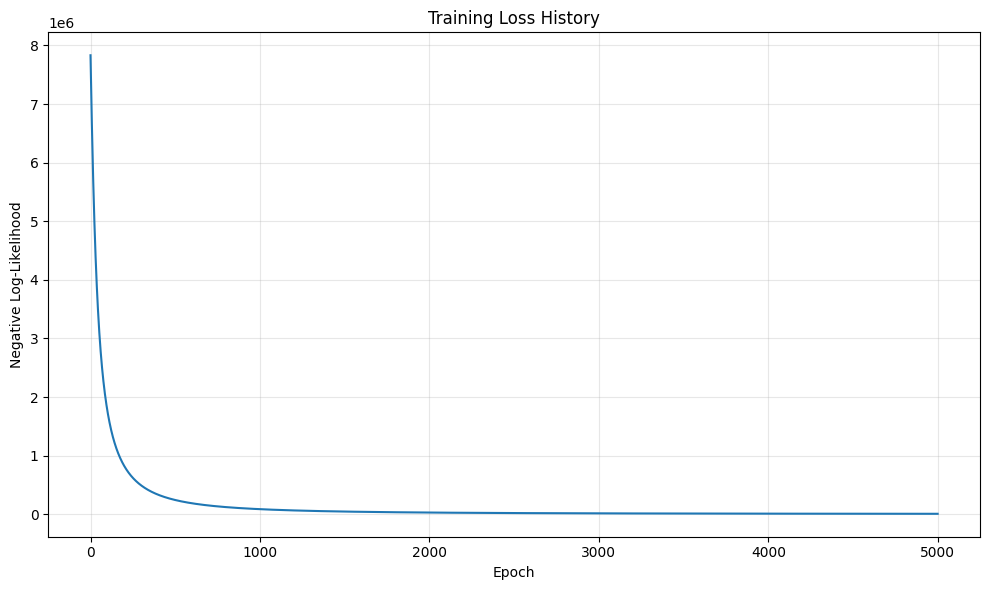

Predictions: [[-7.1496315]
 [ 1.9804437]
 [14.63451  ]
 [ 7.954462 ]
 [11.129111 ]
 [ 7.5537705]
 [ 7.961314 ]
 [-3.4060128]
 [-4.511882 ]
 [-3.4270325]]


In [0]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_regression

# Create synthetic data
n_samples = 1000
n_groups = 20
X, y = make_regression(n_samples=n_samples, n_features=3, noise=0.5)
groups = np.random.choice(range(n_groups), size=n_samples)

# Create a DataFrame
data = pd.DataFrame({
    'x1': X[:, 0],
    'x2': X[:, 1], 
    'x3': X[:, 2],
    'y': y,
    'group': groups
})

# Fit a Gaussian mixed model with random intercept
model = GLMM(
    X=data[['x1', 'x2', 'x3']],
    y=data['y'],
    groups={'Group': data['group']},
    distribution='gaussian',
    link='identity',
    random_effect_cols={'Group': [0]}  # Random intercept (corresponds to intercept column)
)

# Train the model
model.fit(lr=0.01, epochs=5000, verbose=True)

# Examine results
model.summary()
model.plot_loss()

# Make predictions
new_data = pd.DataFrame({
    'x1': np.random.normal(size=10),
    'x2': np.random.normal(size=10),
    'x3': np.random.normal(size=10),
    'group': np.random.choice(range(n_groups), size=10)
})

predictions = model.predict(X_new=new_data[['x1', 'x2', 'x3']], groups_new={'Group': new_data['group']})
print("Predictions:", predictions)

## Example 2: Using Formula Notation with Random Slopes


Training with automatic convergence detection...
Tolerance: 0.0001, Patience: 5, Check interval: 100
Epoch 0: Negative Log-Likelihood = 5439992.0000
Epoch 500: Negative Log-Likelihood = 155384.4531
Epoch 1000: Negative Log-Likelihood = 55034.3711
Epoch 1500: Negative Log-Likelihood = 28992.5176
Epoch 2000: Negative Log-Likelihood = 18207.2832
Epoch 2500: Negative Log-Likelihood = 12682.5264
Epoch 3000: Negative Log-Likelihood = 9488.8154
Epoch 3500: Negative Log-Likelihood = 7496.5498
Epoch 4000: Negative Log-Likelihood = 6189.5439
Epoch 4500: Negative Log-Likelihood = 5302.5659
Epoch 5000: Negative Log-Likelihood = 4687.0879
Epoch 5500: Negative Log-Likelihood = 4254.2036
Epoch 6000: Negative Log-Likelihood = 3947.8123
Epoch 6500: Negative Log-Likelihood = 3730.9316
Epoch 7000: Negative Log-Likelihood = 3578.2812
Epoch 7500: Negative Log-Likelihood = 3472.0098
Epoch 8000: Negative Log-Likelihood = 3399.1538
Epoch 8500: Negative Log-Likelihood = 3350.0244
Epoch 9000: Negative Log-Likel

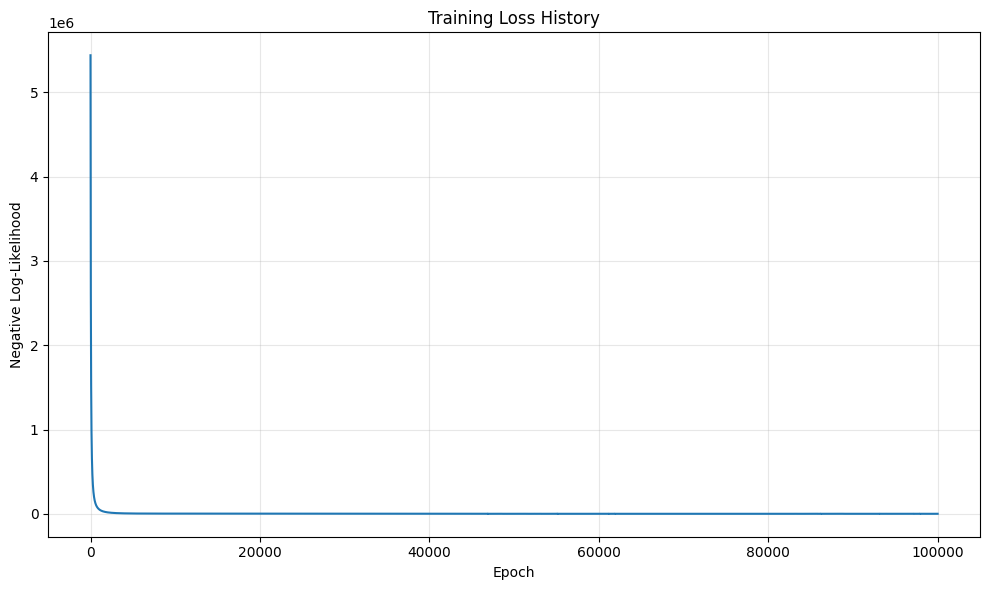


Predicted scores for new students:
Student at School_28: math=0.89, study=5.75, private=1 → predicted score: 160.41
Student at School_30: math=0.84, study=11.53, private=1 → predicted score: 183.45
Student at School_40: math=-0.88, study=4.59, private=0 → predicted score: 144.75
Student at School_32: math=0.28, study=1.06, private=0 → predicted score: 136.18
Student at School_47: math=0.40, study=9.58, private=0 → predicted score: 171.03


In [0]:
import pandas as pd
import numpy as np

# Generate synthetic data
n_samples = 500
n_schools = 25
n_students_per_school = n_samples // n_schools

schools = np.repeat(range(n_schools), n_students_per_school)
math_aptitude = np.random.normal(0, 1, n_samples)
hours_studied = np.random.gamma(shape=2, scale=2, size=n_samples)
is_private = np.random.choice([0, 1], size=n_samples, p=[0.7, 0.3])

# Create random intercepts and slopes per school
school_intercepts = np.random.normal(70, 5, n_schools)
school_slopes = np.random.normal(2, 0.5, n_schools)

# Generate test scores with both fixed and random effects
base_score = 60 + 5 * math_aptitude + 2 * hours_studied + 3 * is_private
school_effect = np.array([school_intercepts[s] for s in schools])
study_effect = np.array([school_slopes[s] * hours_studied[i] for i, s in enumerate(schools)])
scores = base_score + school_effect + study_effect + np.random.normal(0, 5, n_samples)

# Create a DataFrame
data = pd.DataFrame({
    'student_id': range(n_samples),
    'school': [f"School_{i}" for i in schools],
    'math_aptitude': math_aptitude,
    'hours_studied': hours_studied,
    'is_private': is_private,
    'score': scores
})

# Fit the model using formula notation with random slope
model = GLMM(
    formula="score ~ math_aptitude + hours_studied + is_private + (1 + hours_studied | school)",
    data=data,
    distribution='gaussian'
)

# Train with automatic convergence detection
model.fit(lr=0.01, convergence=True, tol=1e-4, verbose=True)

# Check the random effects
print("\nRandom Effects by School:")
print(model.ranef['school'].head(10))

# Visualize
model.plot_loss()

# Make predictions for new students
new_students = pd.DataFrame({
    'math_aptitude': np.random.normal(0, 1, 5),
    'hours_studied': np.random.gamma(shape=2, scale=2, size=5),
    'is_private': np.random.choice([0, 1], size=5),
    'school': np.random.choice(data['school'].unique(), size=5)
})

predicted_scores = model.predict(new_data=new_students)
print("\nPredicted scores for new students:")
for i, (idx, student) in enumerate(new_students.iterrows()):
    print(f"Student at {student['school']}: math={student['math_aptitude']:.2f}, "
          f"study={student['hours_studied']:.2f}, private={student['is_private']} → "
          f"predicted score: {predicted_scores[i][0]:.2f}")

## Example 3: Binomial Model for Survey Data


In [0]:
import pandas as pd
import numpy as np

# Generate synthetic survey data
n_questions = 200
n_respondents = 50

# Respondent characteristics
age = np.random.uniform(18, 70, n_respondents)
education = np.random.choice([1, 2, 3, 4], size=n_respondents)  # 1=HS, 2=College, 3=Masters, 4=PhD
gender = np.random.choice(['M', 'F', 'O'], size=n_respondents, p=[0.48, 0.48, 0.04])

# Question difficulty and discrimination
difficulty = np.random.normal(0, 1, n_questions)

# Response data
data_rows = []
for r in range(n_respondents):
    for q in range(n_questions):
        # Probability of correct answer based on respondent ability and question difficulty
        respondent_ability = 0.5 + 0.01 * age[r] + 0.2 * education[r] + np.random.normal(0, 0.5)
        p_correct = 1 / (1 + np.exp(-(respondent_ability - difficulty[q])))
        
        # Generate success/failure
        correct = np.random.binomial(1, p_correct)
        incorrect = 1 - correct
        
        data_rows.append({
            'respondent_id': f"R{r+1}",
            'question_id': f"Q{q+1}",
            'age': age[r],
            'education': education[r],
            'gender': gender[r],
            'correct': correct,
            'incorrect': incorrect
        })

survey_data = pd.DataFrame(data_rows)

# Create dummy variables for gender
gender_dummies = pd.get_dummies(survey_data['gender'], prefix='gender', drop_first=True)
survey_data = pd.concat([survey_data, gender_dummies], axis=1)

# Fit a binomial GLMM with random intercepts for both respondents and questions
model = GLMM(
    formula="cbind(correct, incorrect) ~ age + education + gender_F + gender_O + (1 | respondent_id) + (1 | question_id)",
    data=survey_data,
    distribution='binomial',
    link='logit'
)

# Train the model
model.fit(lr=0.01, epochs=3000, verbose=True)

# Model summary
model.summary()

# Examine respondent random effects
print("\nRespondent Random Effects (first 10):")
print(model.ranef['respondent_id'].head(10))

# Examine question random effects
print("\nQuestion Random Effects (first 10):")
print(model.ranef['question_id'].head(10))

# Predict probability of correct response for new data
new_responses = pd.DataFrame({
    'respondent_id': np.random.choice(survey_data['respondent_id'].unique(), size=5),
    'question_id': np.random.choice(survey_data['question_id'].unique(), size=5),
    'age': np.random.uniform(18, 70, 5),
    'education': np.random.choice([1, 2, 3, 4], size=5),
    'gender': np.random.choice(['M', 'F', 'O'], size=5)
})

# Create the same dummy variables as in training
gender_dummies = pd.get_dummies(new_responses['gender'], prefix='gender', drop_first=True)
for col in ['gender_F', 'gender_O']:
    if col not in gender_dummies:
        gender_dummies[col] = 0
new_responses = pd.concat([new_responses, gender_dummies], axis=1)

# Predict probabilities
predicted_probs = model.predict(new_data=new_responses)
print("\nPredicted probabilities of correct response:")
for i, (idx, resp) in enumerate(new_responses.iterrows()):
    print(f"Respondent {resp['respondent_id']} on question {resp['question_id']}: {predicted_probs[i][0]:.3f}")

Epoch 0: Negative Log-Likelihood = 7161.2080
Epoch 500: Negative Log-Likelihood = 4895.9814
Epoch 1000: Negative Log-Likelihood = 4871.9536
Epoch 1500: Negative Log-Likelihood = 4775.9458
Epoch 2000: Negative Log-Likelihood = 4777.8530
Epoch 2500: Negative Log-Likelihood = 4761.7598
Epoch 2999: Negative Log-Likelihood = 4759.3335
Final negative log-likelihood: 4759.333496
Fixed Effects (beta):
    Variable  Coefficient
0  Intercept     0.460474
1        age     0.008303
2  education     0.168424
3   gender_O    -0.053889

Random Effects for 'respondent_id':
Random Effects Std Dev (sigma_b) per component:
    Variable  Std Dev
0  Intercept  0.00045

Random Effects for 'question_id':
Random Effects Std Dev (sigma_b) per component:
    Variable   Std Dev
0  Intercept  0.712727

Model Information:
Distribution: binomial
Link function: logit
Number of observations: 10000
Number of groups in 'respondent_id': 50
Number of groups in 'question_id': 200

Convergence Information:
Converged: None


## Example 4: Poisson Model for Count Data

In [0]:
import pandas as pd
import numpy as np

# Generate synthetic count data (e.g., number of fish caught)
n_anglers = 50
n_locations = 10
n_observations = 200

# Angler and location characteristics
angler_skill = np.random.normal(0, 1, n_anglers)
location_quality = np.random.normal(0, 1, n_locations)

# Environmental factors
temperature = np.random.uniform(10, 30, n_observations)
wind_speed = np.random.uniform(0, 20, n_observations)
is_weekend = np.random.choice([0, 1], size=n_observations, p=[0.7, 0.3])

# Generate data
data_rows = []
for i in range(n_observations):
    angler_id = np.random.randint(0, n_anglers)
    location_id = np.random.randint(0, n_locations)
    
    # Expected count based on fixed and random effects
    log_lambda = (
        1.0 +  # baseline
        0.05 * temperature[i] - 
        0.1 * wind_speed[i] + 
        0.5 * is_weekend[i] +
        angler_skill[angler_id] +
        location_quality[location_id]
    )
    
    lambda_val = np.exp(log_lambda)
    fish_count = np.random.poisson(lambda_val)
    
    data_rows.append({
        'angler_id': f"A{angler_id+1}",
        'location_id': f"L{location_id+1}",
        'temperature': temperature[i],
        'wind_speed': wind_speed[i],
        'is_weekend': is_weekend[i],
        'fish_count': fish_count
    })

fishing_data = pd.DataFrame(data_rows)

# Fit a Poisson mixed model
model = GLMM(
    formula="fish_count ~ temperature + wind_speed + is_weekend + (1 | angler_id) + (1 | location_id)",
    data=fishing_data,
    distribution='poisson',
    link='log'
)

# Train with L2 regularization
model.fit(lr=0.01, epochs=3000, verbose=True)

# Model summary
model.summary()

# Check fixed effects estimates 
print("Fixed Effects for Environmental Factors:")
fixed_effects = model.fixef[['temperature', 'wind_speed', 'is_weekend']]
print(fixed_effects)

# Check random effects for anglers
print("\nAngler Random Effects (skill, top 5):")
top_anglers = model.ranef['angler_id'].sort_values('Intercept', ascending=False).head(5)
print(top_anglers)

# Check random effects for locations
print("\nLocation Random Effects (quality, top 5):")
top_locations = model.ranef['location_id'].sort_values('Intercept', ascending=False).head(5)
print(top_locations)

# Predict fish counts for new fishing trips
new_trips = pd.DataFrame({
    'angler_id': np.random.choice(fishing_data['angler_id'].unique(), size=5),
    'location_id': np.random.choice(fishing_data['location_id'].unique(), size=5),
    'temperature': np.random.uniform(10, 30, 5),
    'wind_speed': np.random.uniform(0, 20, 5),
    'is_weekend': np.random.choice([0, 1], size=5)
})

predicted_counts = model.predict(new_data=new_trips)
print("\nPredicted fish counts for new trips:")
for i, (idx, trip) in enumerate(new_trips.iterrows()):
    print(f"Angler {trip['angler_id']} at {trip['location_id']} "
          f"(temp={trip['temperature']:.1f}°C, wind={trip['wind_speed']:.1f}km/h, "
          f"weekend={bool(trip['is_weekend'])}): {predicted_counts[i][0]:.2f} fish")

Epoch 0: Negative Log-Likelihood = 8884.4658
Epoch 500: Negative Log-Likelihood = 495.2489
Epoch 1000: Negative Log-Likelihood = 487.8095
Epoch 1500: Negative Log-Likelihood = 487.6596
Epoch 2000: Negative Log-Likelihood = 487.6259
Epoch 2500: Negative Log-Likelihood = 487.5924
Epoch 2999: Negative Log-Likelihood = 487.5606
Final negative log-likelihood: 487.560577
Fixed Effects (beta):
      Variable  Coefficient
0    Intercept     1.378686
1  temperature     0.053341
2   wind_speed    -0.096175
3   is_weekend     0.575471

Random Effects for 'angler_id':
Random Effects Std Dev (sigma_b) per component:
    Variable   Std Dev
0  Intercept  0.889273

Random Effects for 'location_id':
Random Effects Std Dev (sigma_b) per component:
    Variable  Std Dev
0  Intercept  1.03044

Model Information:
Distribution: poisson
Link function: log
Number of observations: 200
Number of groups in 'angler_id': 47
Number of groups in 'location_id': 10

Convergence Information:
Converged: None
Total epoch

## Example 5: Gamma Model for Positive Continuous Data


In [0]:
import pandas as pd
import numpy as np

# Generate synthetic insurance claim data
n_policyholders = 300
n_regions = 20
n_observations = 500

# Policyholder and region characteristics
policyholder_risk = np.random.gamma(2, 0.5, n_policyholders)  # Shape, scale
region_risk = np.random.gamma(2, 0.5, n_regions)

# Create data rows
data_rows = []
for i in range(n_observations):
    policyholder_id = np.random.randint(0, n_policyholders)
    region_id = np.random.randint(0, n_regions)
    
    # Factors affecting claim amount
    age = np.random.uniform(18, 80)
    vehicle_age = np.random.uniform(0, 15)
    vehicle_value = np.random.uniform(5000, 50000)
    is_sports_car = np.random.choice([0, 1], p=[0.9, 0.1])
    
    # Expected mean claim amount (shape parameter for gamma)
    log_mean = (
        7.0 +  # baseline (around $1000)
        0.01 * age +
        0.05 * vehicle_age -
        0.00001 * vehicle_value +
        0.5 * is_sports_car +
        np.log(policyholder_risk[policyholder_id]) +
        np.log(region_risk[region_id])
    )
    
    mean_claim = np.exp(log_mean)
    shape = 2.0  # Fixed shape parameter for gamma
    scale = mean_claim / shape
    claim_amount = np.random.gamma(shape, scale)
    
    data_rows.append({
        'policyholder_id': f"P{policyholder_id+1}",
        'region_id': f"R{region_id+1}",
        'age': age,
        'vehicle_age': vehicle_age,
        'vehicle_value': vehicle_value / 10000,  # Scale for numerical stability
        'is_sports_car': is_sports_car,
        'claim_amount': claim_amount
    })

claim_data = pd.DataFrame(data_rows)

# Fit a Gamma mixed model
model = GLMM(
    formula="claim_amount ~ age + vehicle_age + vehicle_value + is_sports_car + (1 | policyholder_id) + (1 | region_id)",
    data=claim_data,
    distribution='gamma',
    link='log'
)

# Train the model
model.fit(lr=0.001, convergence=True, tol=1e-4, verbose=True)

# Model summary
model.summary()

# Examine model coefficients
print("\nFixed Effects (impact on mean claim amount):")
print(model.fixef[['age', 'vehicle_age', 'vehicle_value', 'is_sports_car']])

# Check highest risk regions
print("\nRegions with Highest Risk (top 5):")
high_risk_regions = model.ranef['region_id'].sort_values('Intercept', ascending=False).head(5)
print(high_risk_regions)

# Predict claim amounts for new policies
new_policies = pd.DataFrame({
    'policyholder_id': np.random.choice(claim_data['policyholder_id'].unique(), size=5),
    'region_id': np.random.choice(claim_data['region_id'].unique(), size=5),
    'age': np.random.uniform(18, 80, 5),
    'vehicle_age': np.random.uniform(0, 15, 5),
    'vehicle_value': np.random.uniform(0.5, 5.0, 5),  # Already scaled
    'is_sports_car': np.random.choice([0, 1], size=5, p=[0.9, 0.1])
})

predicted_claims = model.predict(new_data=new_policies)
print("\nPredicted claim amounts for new policies:")
for i, (idx, policy) in enumerate(new_policies.iterrows()):
    print(f"Policyholder {policy['policyholder_id']} in region {policy['region_id']}: "
          f"${predicted_claims[i][0]:.2f}")

Training with automatic convergence detection...
Tolerance: 0.0001, Patience: 5, Check interval: 100
Epoch 0: Negative Log-Likelihood = 815446.0625
Epoch 500: Negative Log-Likelihood = 10625.6582
Epoch 1000: Negative Log-Likelihood = 6429.8433
Epoch 1500: Negative Log-Likelihood = 5361.6030
Epoch 2000: Negative Log-Likelihood = 4970.9575
Epoch 2500: Negative Log-Likelihood = 4803.7568
Epoch 3000: Negative Log-Likelihood = 4711.9233
Epoch 3500: Negative Log-Likelihood = 4642.3750
Epoch 4000: Negative Log-Likelihood = 4565.6411
Epoch 4500: Negative Log-Likelihood = 4435.5527
Epoch 5000: Negative Log-Likelihood = 4145.5024
Epoch 5500: Negative Log-Likelihood = 3890.0288
Epoch 6000: Negative Log-Likelihood = 3682.9675
Epoch 6500: Negative Log-Likelihood = 3493.4956
Epoch 7000: Negative Log-Likelihood = 3314.7144
Epoch 7500: Negative Log-Likelihood = 3144.8384
Epoch 8000: Negative Log-Likelihood = 2982.5674
Epoch 8500: Negative Log-Likelihood = 2828.7886
Epoch 9000: Negative Log-Likelihood 

## Example 6: Categorical Predictors and Regularization


In [0]:
import pandas as pd
import numpy as np

# Generate synthetic employee satisfaction data
n_employees = 200
n_departments = 8
n_managers = 20

# Employee characteristics
age = np.random.uniform(22, 65, n_employees)
tenure = np.random.uniform(0, 20, n_employees)
education = np.random.choice(['High School', 'Bachelor', 'Master', 'PhD'], size=n_employees)
role = np.random.choice(['Junior', 'Mid-level', 'Senior', 'Lead'], size=n_employees)

# Department and manager random effects
department_effect = np.random.normal(0, 0.5, n_departments)
manager_effect = np.random.normal(0, 0.4, n_managers)

# Generate department and manager assignments
department_id = np.random.choice(range(n_departments), size=n_employees)
manager_id = np.random.choice(range(n_managers), size=n_employees)

# Generate satisfaction scores
base_satisfaction = 3.0
age_effect = 0.01 * (age - 40)  # Centered at 40
tenure_effect = 0.05 * tenure
education_effect = {
    'High School': 0.0, 
    'Bachelor': 0.1, 
    'Master': 0.2, 
    'PhD': 0.3
}
role_effect = {
    'Junior': -0.2, 
    'Mid-level': 0.0, 
    'Senior': 0.3, 
    'Lead': 0.5
}

# Calculate mean satisfaction
satisfaction = np.zeros(n_employees)
for i in range(n_employees):
    satisfaction[i] = (
        base_satisfaction +
        age_effect[i] +
        tenure_effect[i] +
        education_effect[education[i]] +
        role_effect[role[i]] +
        department_effect[department_id[i]] +
        manager_effect[manager_id[i]] +
        np.random.normal(0, 0.3)  # Noise term
    )

# Clip to valid range
satisfaction = np.clip(satisfaction, 1, 5)

# Create dataframe
employee_data = pd.DataFrame({
    'employee_id': [f"E{i+1}" for i in range(n_employees)],
    'age': age,
    'tenure': tenure,
    'education': education,
    'role': role,
    'department_id': [f"D{i+1}" for i in department_id],
    'manager_id': [f"M{i+1}" for i in manager_id],
    'satisfaction': satisfaction
})

# Fit the model with categorical predictors and L2 regularization
model = GLMM(
    formula="satisfaction ~ age + tenure + education + role + (1 | department_id) + (1 | manager_id)",
    data=employee_data,
    distribution='gaussian',
    link='identity',
    regularization='L2',
    reg_lambda=0.1
)

# Train the model
model.fit(lr=0.01, epochs=3000, verbose=True)

# Model summary
model.summary()

# Examine the effect of categorical variables
print("\nFixed Effects for Education Levels:")
education_effects = [col for col in model.fixef.index if 'education' in col]
print(model.fixef[education_effects])

print("\nFixed Effects for Roles:")
role_effects = [col for col in model.fixef.index if 'role' in col]
print(model.fixef[role_effects])

# Check department effects
print("\nDepartment Random Effects:")
print(model.ranef['department_id'].sort_values('Intercept', ascending=False))

# Manager effects
print("\nManager Random Effects (top and bottom 3):")
manager_effects = model.ranef['manager_id'].sort_values('Intercept', ascending=False)
print("Top 3 managers:")
print(manager_effects.head(3))
print("\nBottom 3 managers:")
print(manager_effects.tail(3))

# Predict satisfaction for new employees
new_employees = pd.DataFrame({
    'age': np.random.uniform(22, 65, 5),
    'tenure': np.random.uniform(0, 20, 5),
    'education': np.random.choice(['High School', 'Bachelor', 'Master', 'PhD'], size=5),
    'role': np.random.choice(['Junior', 'Mid-level', 'Senior', 'Lead'], size=5),
    'department_id': np.random.choice(employee_data['department_id'].unique(), size=5),
    'manager_id': np.random.choice(employee_data['manager_id'].unique(), size=5)
})

predicted_satisfaction = model.predict(new_data=new_employees)
print("\nPredicted satisfaction scores for new employees:")
for i, (idx, emp) in enumerate(new_employees.iterrows()):
    print(f"{emp['role']} with {emp['education']} degree, age {emp['age']:.1f}, "
          f"tenure {emp['tenure']:.1f} years, in department {emp['department_id']} "
          f"under manager {emp['manager_id']}: {predicted_satisfaction[i][0]:.2f}/5.0")

Epoch 0: Negative Log-Likelihood = 1835.9475
Epoch 500: Negative Log-Likelihood = 59.0581
Epoch 1000: Negative Log-Likelihood = 54.7174
Epoch 1500: Negative Log-Likelihood = 50.6652
Epoch 2000: Negative Log-Likelihood = 50.4187
Epoch 2500: Negative Log-Likelihood = 50.4174
Epoch 2999: Negative Log-Likelihood = 50.4174
Final negative log-likelihood: 50.417366
Fixed Effects (beta):
                Variable  Coefficient
0              Intercept     2.690488
1                    age     0.009039
2                 tenure     0.049134
3  education_High School    -0.064921
4       education_Master     0.141812
5          education_PhD     0.233640
6              role_Lead     0.593467
7         role_Mid-level     0.165161
8            role_Senior     0.417775

Random Effects for 'department_id':
Random Effects Std Dev (sigma_b) per component:
    Variable   Std Dev
0  Intercept  0.431042

Random Effects for 'manager_id':
Random Effects Std Dev (sigma_b) per component:
    Variable   Std Dev
0